In [2]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax): # format x axis for plots
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data(): # get flu surveillance data from flusight forecast hub
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})


# get flu scenario modeling hub predictions for each model and submission date
def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on the
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


In [5]:
# format observations into a standard dataframe format
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [10]:
# download observed data
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-04-27,02,Alaska,3,0.421688
1,2,2024-04-27,01,Alabama,16,0.315970
2,3,2024-04-27,05,Arkansas,30,0.986233
3,4,2024-04-27,04,Arizona,106,1.443941
4,5,2024-04-27,06,California,151,0.388309
...,...,...,...,...,...,...
6143,6144,2022-02-12,50,Vermont,0,0.000000
6144,6145,2022-02-12,53,Washington,8,0.103415
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6146,6147,2022-02-12,54,West Virginia,5,0.281694


In [19]:
# download Flu SMH predictions for MOBS model
models = ['MOBS_NEU-GLEAM_FLU']
dates = '2023-09-03'
rd = 4

for model in models:
    predictions = pull_flu_scenario_modeling_hub_predictions(model,dates)
    predictions['Model'] = model
    
    predictions = predictions[predictions['target'] =='inc hosp']


    numweeks = list(predictions.horizon.unique())

    start_date = list(predictions.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    df = predictions.merge(dfdates, how='inner', on='horizon')


    df.to_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd{rd}.pq', index=False)
    


In [20]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

# Sample MOBS model

In [18]:
# sample trajectories and calculate energy score

target_obs = 'hospitalization'

locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

# include all models, even those only submitting for one location
modelsall = ['MOBS_NEU-GLEAM_FLU']

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

# dates for filtering
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
# get predictions for each model
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data

predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    

# sample trajectories with different numbers of samples
for numsamps in [5,10,25,50]:
     
    for it in range(1):

        loclist = list(predictionsall.location.unique())

        a = list(predictionsall.trajectory_id.unique())
        samps = random.sample(a, numsamps)

        predictionssamp = predictionsall[predictionsall.trajectory_id.isin(samps) ]


        for loc in loclist:
            if loc in ['60','66','69', '72', '78']:
                continue
            for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
                location = loc
                target = 'hosp'
                incidence = True

                if target == 'hosp':
                    target_obs = 'hospitalization'
                else:
                    target_obs = target_obs

                predictionsfilt = predictionssamp[(predictionssamp.scenario_id == scenario + '-2023-08-14') & \
                                            (predictionssamp.location == location) & \
                                            (predictionssamp.target == 'inc ' + target)  & \
                                            (predictionssamp.target_end_date <= max_date) & \
                                            (predictionssamp.target_end_date >= start_week)]

                if len(predictionsfilt)==0:
                    continue

                # get observations
                observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
                observations['date'] = pd.to_datetime(observations['date'])

                observations = observations[(observations['date'] >= start_week) & \
                                            (observations['date'] <= max_date)]   

                #filter location
                observations = observations[observations['location'] == location]

                #aggregate to weekly
                observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

                #transform to Observation object
                observations = Observations(observations)

                # calculate energy score
                y = np.array(observations.value)
                X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

                ES = energyscore(np.array(X),y)

                if loc == 'US':
                    loc_conv = loc
                elif int(loc) <10:
                    loc_conv = loc[1]
                else:
                    loc_conv = loc  

                # format into dataframe
                newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                                    'target':target, 'energyscore': ES, 'numsamps':numsamps}, index=[0])

                energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [161]:
energyscoresdf

,Label,location,target,energyscore,numsamps,abbreviation,location_name,population
0,Scenario A,1,hosp,466.086210,5,AL,Alabama,4903185
1,Scenario B,1,hosp,588.452052,5,AL,Alabama,4903185
2,Scenario C,1,hosp,464.351080,5,AL,Alabama,4903185
3,Scenario D,1,hosp,493.366111,5,AL,Alabama,4903185
4,Scenario E,1,hosp,511.505959,5,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
62395,Scenario B,US,hosp,26348.539424,50,US,US,328728466
62396,Scenario C,US,hosp,25005.636770,50,US,US,328728466
62397,Scenario D,US,hosp,24867.396506,50,US,US,328728466
62398,Scenario E,US,hosp,22282.598598,50,US,US,328728466


In [162]:
energyscoresdf.to_pickle('../fludat/MOBS_sampled.pkl')

In [21]:
# full energy score
# calculated in energyscore_flu_rd4.ipynb script
energyscoresdf_true = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


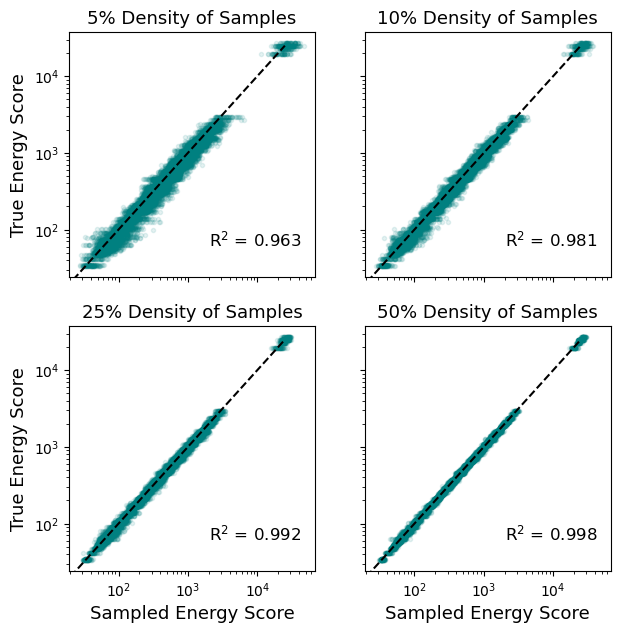

In [8]:
# plot full energy score compared to sampled energy score
energyscoresdf_true = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf_true = energyscoresdf_true[energyscoresdf_true.Model == 'MOBS_NEU-GLEAM_FLU']
energyscoresdf_true = energyscoresdf_true.rename(columns={'energyscore':'energyscore_true'})
energyscoresdf_samp = pd.read_pickle('../fludat/MOBS_sampled.pkl').rename(columns={'energyscore':'energyscore_samp'})


ESdf = energyscoresdf_samp.merge(energyscoresdf_true, on=['location', 'Label', 'abbreviation', 'location_name', 
                                                   'population', 'target'])


fig,ax = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

i=1
for numsamp in ESdf.numsamps.unique():

    plt.subplot(2,2,i)
    
    df = ESdf[ESdf.numsamps == numsamp]

    plt.plot(df.energyscore_samp, df.energyscore_true, '.',alpha=.1, color='teal')
    plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    slope, intercept, r_value, p_value, std_err = linregress(df.energyscore_samp, 
                                                             df.energyscore_true)

    plt.text(2000,60, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=12)
    plt.title(f'{int((numsamp/100)*100)}% Density of Samples', fontsize=13)
    
    if i in [1,3]:
        plt.ylabel('True Energy Score', fontsize=13)
    
    if i in [3,4]:
        plt.xlabel('Sampled Energy Score', fontsize=13)

    i+=1
plt.savefig('../figs/samples_flurd4_MOBS_1216.pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


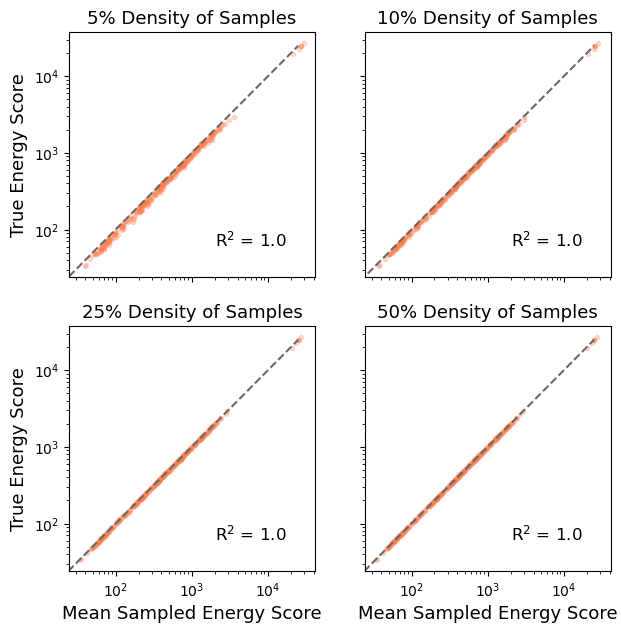

In [7]:
# compare full energy score and the average of all the samples from sampled energy score
energyscoresdf_true = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf_true = energyscoresdf_true[energyscoresdf_true.Model == 'MOBS_NEU-GLEAM_FLU']
energyscoresdf_true = energyscoresdf_true.rename(columns={'energyscore':'energyscore_true'})
energyscoresdf_samp = pd.read_pickle('../fludat/MOBS_sampled.pkl').rename(columns={'energyscore':'energyscore_samp'})


ESdf = energyscoresdf_samp.merge(energyscoresdf_true, on=['location', 'Label', 'abbreviation', 'location_name', 
                                                   'population', 'target'])


fig,ax = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

i=1
for numsamp in ESdf.numsamps.unique():

    plt.subplot(2,2,i)
    
    df = ESdf[ESdf.numsamps == numsamp]
    df = df.groupby(['Label', 'location']).mean()

    plt.plot(df.energyscore_samp, df.energyscore_true, '.',alpha=.25, color='coral')
    plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='dimgray', linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    slope, intercept, r_value, p_value, std_err = linregress(df.energyscore_samp, 
                                                             df.energyscore_true)

    plt.text(2000,60, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=12)
    plt.title(f'{int((numsamp/100)*100)}% Density of Samples', fontsize=13)
    
    if i in [1,3]:
        plt.ylabel('True Energy Score', fontsize=13)
    
    if i in [3,4]:
        plt.xlabel('Mean Sampled Energy Score', fontsize=13)

    i+=1
#plt.savefig('../figs/samples_avg_flurd4_MOBS.pdf')